In [5]:
import sys
sys.path.insert(0, "./deepsequence_model")

In [6]:
import numpy as np

import pickle
import copy

In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

### MSA array 3d

In [7]:
with open("data_pickle/msa_arr.pickle", 'rb') as f:
    msa_arr = pickle.load(f)

In [6]:
msa_arr.shape

(10813, 286)

In [7]:
msa_arr_3d = np.zeros(shape=(msa_arr.shape[0], msa_arr.shape[1], 20))

In [8]:
for idx_sequence, sequence in enumerate(msa_arr):
    for idx_amino, amino_value in enumerate(sequence):
        if amino_value < 20:
            msa_arr_3d[idx_sequence, idx_amino, amino_value] = 1

In [9]:
msa_arr_3d

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [10]:
import pickle
import os

filepath = "msa_arr_3d.pickle"
output_dir = "./data_pickle"
msa_output_path = os.path.join(output_dir, filepath)
with open(msa_output_path, 'wb') as f:
    pickle.dump(msa_arr_3d, f, protocol=pickle.HIGHEST_PROTOCOL)

### DataHelper

In [9]:
import torch

/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from sklearn.model_selection import train_test_split

from helper import DataHelper

class DataHelperAugmented(DataHelper):

    def __init__(self,
                 x_train_pickle_path,
                 x_train_finetune_pickle_path=None,
                 sel_seq=None):

        super().__init__() 

        self.x_train = self._unpickle_data(x_train_pickle_path)

        if x_train_finetune_pickle_path is not None:
            self.x_train = self.x_train[sel_seq]

        self.seq_len = self.x_train.shape[1]
        self.alphabet_size = 20

        if x_train_finetune_pickle_path is not None:
            self.x_train_finetune = self._unpickle_data(x_train_finetune_pickle_path)
        else:
            self.x_train_finetune = x_train_finetune_pickle_path
        
        self._split_data()
        

    def _unpickle_data(self, data_pickle_path):
        with open(data_pickle_path, 'rb') as pickleFile:
            return pickle.load(pickleFile)

    def _split_data(self):
        if self.x_train_finetune is not None:

            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x_train_finetune, self.x_train, test_size=0.2, random_state=42)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x_train, self.x_train, test_size=0.2, random_state=42)

## Baseline

### Baseline DataHelper

In [11]:
path_msa_3d = 'data_pickle/msa_arr_3d.pickle'
baseline_data_helper = DataHelperAugmented(x_train_pickle_path=path_msa_3d)

In [12]:
baseline_data_helper.x_train.shape

(10813, 286, 20)

### Visualization training

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def viz_training(track_epoch_vars, title):
    
    df_viz = pd.DataFrame(track_epoch_vars)
    df_viz = df_viz.astype('float')
    df_viz['epoch'] = (df_viz.index+1)*100

    sns.lineplot(x = "epoch", y = "train_loss", data = df_viz, color='green', linewidth=10)
    sns.lineplot(x = "epoch", y = "validation_loss", data = df_viz, color='red')
    plt.ylabel(title)

    plt.xticks(rotation = 20)

    plt.show()

### Baseline Model VAE

In [13]:
from model import VAE

model = VAE(baseline_data_helper, bayesian=False)

In [12]:
model

VAE(
  (fc1): Linear(in_features=5720, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=1500, bias=True)
  (fc3_mu): Linear(in_features=1500, out_features=40, bias=True)
  (fc3_logvar): Linear(in_features=1500, out_features=40, bias=True)
  (bfc4): Linear(in_features=40, out_features=100, bias=False)
  (bfc5): Linear(in_features=100, out_features=2000, bias=True)
  (bfc6): Linear(in_features=2000, out_features=5720, bias=True)
)

In [13]:
model_bayesian = VAE(baseline_data_helper, bayesian=True)

In [14]:
model_bayesian

VAE(
  (fc1): Linear(in_features=5720, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=1500, bias=True)
  (fc3_mu): Linear(in_features=1500, out_features=40, bias=True)
  (fc3_logvar): Linear(in_features=1500, out_features=40, bias=True)
  (bfc4): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (bfc5): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (bfc6): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)

### Baseline Training, NO bayesian

In [25]:
from train import train

In [26]:
model_trained, track_epoch_vars = train(baseline_data_helper, 
                                        copy.deepcopy(model), 
                                        kl_latent_scale=0.0001,
                                        kl_weights_scale=0,  
                                        lr=0.001,
                                        num_updates=3000,
                                        batch_size=100)

Using device: cuda:0


Epoch: 0
	MSE loss: 0.25048187375068665
	KL latent loss: 0.02068828046321869
	KL weights loss: 0
	Total loss:0.2504839301109314

	Validation loss: 0.211551234126091


Epoch: 100
	MSE loss: 0.023571491241455078
	KL latent loss: 3.334203004837036
	KL weights loss: 0
	Total loss:0.023904912173748016

	Validation loss: 0.024008654057979584


Epoch: 200
	MSE loss: 0.021942682564258575
	KL latent loss: 7.070750713348389
	KL weights loss: 0
	Total loss:0.02264975756406784

	Validation loss: 0.02237166091799736


Epoch: 300
	MSE loss: 0.02050182595849037
	KL latent loss: 8.719843864440918
	KL weights loss: 0
	Total loss:0.0213738102465868

	Validation loss: 0.021369507536292076


Epoch: 400
	MSE loss: 0.020012278109788895
	KL latent loss: 9.954935073852539
	KL weights loss: 0
	Total loss:0.021007772535085678

	Validation loss: 0.020623980090022087


Epoch: 500
	MSE loss: 0.01963978260755539
	KL latent loss: 11.442510604858398
	KL weights loss: 0
	Total loss:0.02078403346

In [27]:
viz_training(track_epoch_vars, title="Baseline model, NO bayesian")

NameError: name 'viz_training' is not defined

In [47]:
torch.save(model_trained, "model_checkpoints/model_trained.pt")

### Baseline Training AND bayesian

In [16]:
model_trained, track_epoch_vars = train(baseline_data_helper, 
                                        copy.deepcopy(model_bayesian), 
                                        kl_latent_scale=0.0001,
                                        kl_weights_scale=0.00001,  
                                        lr=0.001,
                                        num_updates=3000,
                                        batch_size=100)

Using device: cuda:0


Epoch: 0
	MSE loss: 0.32161200046539307
	KL latent loss: 0.016448043286800385
	KL weights loss: 54738216.0
	Total loss:547.7037353515625

	Validation loss: 546.6405029296875


Epoch: 100
	MSE loss: 0.02900957688689232
	KL latent loss: 56.88498306274414
	KL weights loss: 48914188.0
	Total loss:489.17657470703125

	Validation loss: 488.8691101074219


Epoch: 200
	MSE loss: 0.027274800464510918
	KL latent loss: 48.671043395996094
	KL weights loss: 46840692.0
	Total loss:468.4390563964844

	Validation loss: 468.2857360839844


Epoch: 300
	MSE loss: 0.02708708867430687
	KL latent loss: 43.40116500854492
	KL weights loss: 45476788.0
	Total loss:454.79931640625

	Validation loss: 454.697509765625


Epoch: 400
	MSE loss: 0.02776109054684639
	KL latent loss: 41.72837448120117
	KL weights loss: 44274512.0
	Total loss:442.77703857421875

	Validation loss: 442.6436767578125


Epoch: 500
	MSE loss: 0.027064267545938492
	KL latent loss: 48.15192413330078
	KL weights loss: 4310

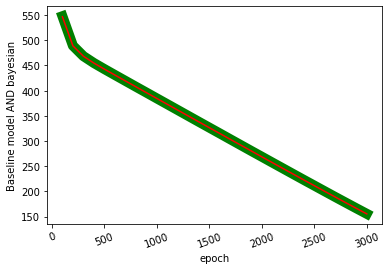

In [17]:
viz_training(track_epoch_vars, title="Baseline model AND bayesian")

## Fine-tuning with MSA representation

OpenFold is trained by giving as an input the MSA of the protein family (which is the input of the baseline model as well). <br>
The dimension of the MSA representation is smaller that the original MSA because only 508 sequences are sampled. <br>
The indices of the original MSA that have been sampled to re-produce the MSA representation are contained in sel_seq.pickle

In [28]:
# Open output from OpenFold and extract the MSA representation

with open("data_pickle/prediction_result/prediction_result.pickle", "rb") as file:
    af_repr1 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_2.pickle", "rb") as file:
    af_repr2 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_3.pickle", "rb") as file:
    af_repr3 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_4.pickle", "rb") as file:
    af_repr4 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_5.pickle", "rb") as file:
    af_repr5 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_6.pickle", "rb") as file:
    af_repr6 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_7.pickle", "rb") as file:
    af_repr7 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_8.pickle", "rb") as file:
    af_repr8 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_9.pickle", "rb") as file:
    af_repr9 = pickle.load(file)['msa'].cpu().numpy()

with open("data_pickle/prediction_result/prediction_result_10.pickle", "rb") as file:
    af_repr10 = pickle.load(file)['msa'].cpu().numpy()

In [29]:
af_repr = np.stack((af_repr1, af_repr2, af_repr3, af_repr4, af_repr5, af_repr6, af_repr7, af_repr8, af_repr9, af_repr10), axis=0).reshape(10*512, 286, 256)
af_repr.shape

(5120, 286, 256)

In [30]:
# Check reshape correctness

(af_repr[512:512*2] == af_repr2).all()

True

In [14]:
# Open sampled indices from the MSA to make the MSA representation

with open("data_pickle/sel_seq/sel_seq.pickle", "rb") as file:
    sel_seq_1 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_2.pickle", "rb") as file:
    sel_seq_2 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_3.pickle", "rb") as file:
    sel_seq_3 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_4.pickle", "rb") as file:
    sel_seq_4 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_5.pickle", "rb") as file:
    sel_seq_5 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_6.pickle", "rb") as file:
    sel_seq_6 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_7.pickle", "rb") as file:
    sel_seq_7 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_8.pickle", "rb") as file:
    sel_seq_8 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_9.pickle", "rb") as file:
    sel_seq_9 = pickle.load(file)

with open("data_pickle/sel_seq/sel_seq_10.pickle", "rb") as file:
    sel_seq_10 = pickle.load(file)

In [15]:
sel_seq = np.stack((sel_seq_1, sel_seq_2, sel_seq_3, sel_seq_4, sel_seq_5, sel_seq_6, sel_seq_7, sel_seq_8, sel_seq_9, sel_seq_10)).reshape(512*10)
sel_seq.shape

(5120,)

In [16]:
with open("data_pickle/not_sel_seq/not_sel_seq.pickle", "rb") as file:
    not_sel_seq = pickle.load(file)

In [36]:
# Just to check
# The index of the selected and non selected amino acids sum up to the total leght of the MSA

len(sel_seq_1) + len(not_sel_seq)

10813

### PCA 

The MSA representation has 256 channels. In order to reproduce the same shape as the normal MSA, we perform PCA on the array

In [37]:
# Reshape the MSA representation as a array 2d, with the challens as second dimension

af_repr_2d = af_repr.reshape(-1, 256)

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=20)

In [40]:
res = pca.fit_transform(af_repr_2d)

In [41]:
# Reshape the MSA representation as a 3d array

res_3d = res.reshape(512*10, 286, 20)

In [42]:
res_3d[0][0]

array([ 82.41773  ,  -1.6984798,  30.116491 ,   2.400448 ,  17.695292 ,
         8.764249 ,  -2.0843606,  18.859676 ,  15.3463745, -14.330377 ,
       -22.709251 ,  -9.658081 , -15.0572   ,  -5.7488914,  27.087688 ,
       -16.149345 , -13.238054 ,  19.058226 , -29.042864 ,  42.33026  ],
      dtype=float32)

### Min-Max scaling

Scale the distribution between 0 and 1 like the MSA one-hot encoding

In [29]:
res_3d_scaled = np.zeros(res_3d.shape)

In [30]:
for i, matr_2d in enumerate(res_3d):
    for j, row in enumerate(matr_2d):

        vect = row
        vect = vect - min(vect)
        vect = vect/max(vect)

        res_3d_scaled[i, j] = vect

In [31]:
# All the number are between 0 and 1
# The index with the highest value now is 1

res_3d_scaled[0][0]

array([1.        , 0.24554059, 0.53087127, 0.28232038, 0.41949639,
       0.33944476, 0.24207556, 0.42996567, 0.39839864, 0.13224897,
       0.05721736, 0.17419189, 0.12581688, 0.20919673, 0.50361538,
       0.11601232, 0.14181456, 0.4323312 , 0.        , 0.63988817])

In [32]:
filepath = "res_3d_scaled.pickle"
output_dir = "./data_pickle"
output_path = os.path.join(output_dir, filepath)
with open(output_path, 'wb') as f:
    pickle.dump(res_3d_scaled, f, protocol=pickle.HIGHEST_PROTOCOL)

## Finetuning DataHelper

In [17]:
finetune_data_helper = DataHelperAugmented(x_train_pickle_path="data_pickle/msa_arr_3d.pickle",
                                           x_train_finetune_pickle_path="data_pickle/res_3d_scaled.pickle",
                                           sel_seq=sel_seq)

In [18]:
from train import train

### Non-bayesian

In [45]:
model_finetune_scratch, track_epoch_vars = train(finetune_data_helper, 
                                                 copy.deepcopy(model),
                                                 kl_latent_scale=0.0001,
                                                 kl_weights_scale=0,  
                                                 lr=0.001,
                                                 batch_size=100,
                                                 num_updates=3000)

Using device: cuda:0


Epoch: 0
	MSE loss: 0.2508215606212616
	KL latent loss: 0.1160542443394661
	KL weights loss: 0
	Total loss:0.2508331537246704

	Validation loss: 0.1842087358236313


Epoch: 100
	MSE loss: 0.022957956418395042
	KL latent loss: 2.8592190742492676
	KL weights loss: 0
	Total loss:0.023243878036737442

	Validation loss: 0.023641852661967278


Epoch: 200
	MSE loss: 0.021287135779857635
	KL latent loss: 6.6955246925354
	KL weights loss: 0
	Total loss:0.021956687793135643

	Validation loss: 0.022428330034017563


Epoch: 300
	MSE loss: 0.021797558292746544
	KL latent loss: 7.87282133102417
	KL weights loss: 0
	Total loss:0.022584840655326843

	Validation loss: 0.021331263706088066


Epoch: 400
	MSE loss: 0.020659059286117554
	KL latent loss: 7.762355804443359
	KL weights loss: 0
	Total loss:0.021435294300317764

	Validation loss: 0.020584793761372566


Epoch: 500
	MSE loss: 0.01803707145154476
	KL latent loss: 9.70343017578125
	KL weights loss: 0
	Total loss:0.01900741457

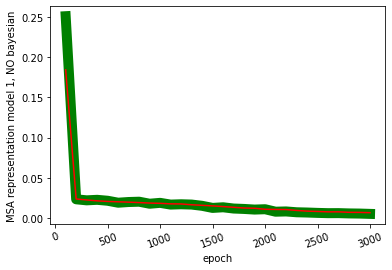

In [46]:
viz_training(track_epoch_vars, title="MSA representation model 1, NO bayesian")

In [47]:
# Lower learning rate

model_finetune_scratch2, track_epoch_vars = train(finetune_data_helper, 
                                                  copy.deepcopy(model_finetune_scratch),
                                                  kl_latent_scale=0.0001,
                                                  kl_weights_scale=0,  
                                                  lr=0.0001,
                                                  batch_size=100,
                                                  num_updates=1000)

Using device: cuda:0


Epoch: 0
	MSE loss: 0.0026289753150194883
	KL latent loss: 20.85991668701172
	KL weights loss: 0
	Total loss:0.004714966751635075

	Validation loss: 0.006120922975242138


Epoch: 100
	MSE loss: 0.002428794512525201
	KL latent loss: 19.24103355407715
	KL weights loss: 0
	Total loss:0.004352897871285677

	Validation loss: 0.005692467559129


Epoch: 200
	MSE loss: 0.0023936533834785223
	KL latent loss: 19.53816795349121
	KL weights loss: 0
	Total loss:0.004347470123320818

	Validation loss: 0.005624652840197086


Epoch: 300
	MSE loss: 0.002671108115464449
	KL latent loss: 19.49542236328125
	KL weights loss: 0
	Total loss:0.004620650317519903

	Validation loss: 0.005603337660431862


Epoch: 400
	MSE loss: 0.002135050017386675
	KL latent loss: 18.996810913085938
	KL weights loss: 0
	Total loss:0.004034731071442366

	Validation loss: 0.005585003644227982


Epoch: 500
	MSE loss: 0.0022656284272670746
	KL latent loss: 18.853511810302734
	KL weights loss: 0
	Total loss:0.

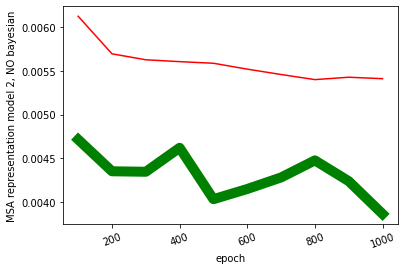

In [48]:
viz_training(track_epoch_vars, title="MSA representation model 2, NO bayesian")

In [49]:
# Even lower learning rate

model_finetune_scratch3, track_epoch_vars = train(finetune_data_helper, 
                                                  copy.deepcopy(model_finetune_scratch2),
                                                  kl_latent_scale=0.0001,
                                                  kl_weights_scale=0,  
                                                  lr=0.00001,
                                                  batch_size=100,
                                                  num_updates=1000)

Using device: cuda:0


Epoch: 0
	MSE loss: 0.0023174823727458715
	KL latent loss: 18.902429580688477
	KL weights loss: 0
	Total loss:0.004207725170999765

	Validation loss: 0.005383235402405262


Epoch: 100
	MSE loss: 0.002164612989872694
	KL latent loss: 18.49266815185547
	KL weights loss: 0
	Total loss:0.0040138796903193

	Validation loss: 0.005367382429540157


Epoch: 200
	MSE loss: 0.002367974491789937
	KL latent loss: 18.90369987487793
	KL weights loss: 0
	Total loss:0.004258344415575266

	Validation loss: 0.005338589195162058


Epoch: 300
	MSE loss: 0.0022715674713253975
	KL latent loss: 18.85169792175293
	KL weights loss: 0
	Total loss:0.004156737122684717

	Validation loss: 0.005261602811515331


Epoch: 400
	MSE loss: 0.0022435931023210287
	KL latent loss: 18.758832931518555
	KL weights loss: 0
	Total loss:0.004119476303458214

	Validation loss: 0.005234654992818832


Epoch: 500
	MSE loss: 0.002413346664980054
	KL latent loss: 18.57581329345703
	KL weights loss: 0
	Total loss:0

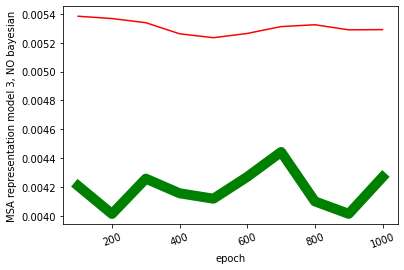

In [50]:
viz_training(track_epoch_vars, title="MSA representation model 3, NO bayesian")

In [45]:
torch.save(model_finetune_scratch3, "model_checkpoints/model_finetune_scratch3.pt")

In [19]:
model_finetune_scratch3 = torch.load("model_checkpoints/model_finetune_scratch3.pt")

In [21]:
model_finetune_scratch3 = torch.load("model_checkpoints/model_finetune_scratch3.pt", map_location=torch.device('cpu'))

### Bayesian

### Testing the model

The actual accuracy is higher that the one below because many sequences have missing amino acids (-) and in this simple evaluation we predict at each position with the argmax over all 20 amino acids. Therefore each prediction at missing position is always wrong unless 0 by chance.

In [27]:
from deepsequence_model.model_performance_tests import reconstruction_accuracy_per_aminoacid

In [68]:
# Performance randomly initialized model

reconstruction_accuracy_per_aminoacid(model, data_helper=baseline_data_helper, n_samples=10)

4.965034965034965

In [69]:
# Performance baseline model

reconstruction_accuracy_per_aminoacid(model_trained, data_helper=baseline_data_helper, n_samples=100)

59.65734265734269

In [72]:
# Performance model learning from scratch - with MSA representation

reconstruction_accuracy_per_aminoacid(model_finetune_scratch, data_helper=finetune_data_helper, n_samples=100, finetune=True)

66.7867132867133

In [62]:
# Performance model learning from scratch - with MSA representation

reconstruction_accuracy_per_aminoacid(model_finetune_scratch3, data_helper=finetune_data_helper, n_samples=100, finetune=True)

70.05244755244755

### Focus sequence prediction distribution at each site

In [70]:
from deepsequence_model.model_performance_tests import distribution_over_amino_acid_focus_sequence

In [20]:
aa_dict = dict()

for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY"):
    aa_dict[aa] = i

In [21]:
focus_sequence = list("MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW")

In [74]:
focus_sequence_index = [aa_dict[x] for x in focus_sequence]
focus_sequence_index[:10]

[10, 15, 7, 13, 6, 4, 14, 17, 0, 9]

In [23]:
# THE ONE-HOT ENCODING USED LEAVES ALL EMPTY FOR 21
# THEREFORE, WHERE THE OUTPUT IS 21, THE PREDICTION IS NOT RELIABLE

focus_sequence_one_hot = np.zeros(shape=(len(focus_sequence_index), 20))

for idx_amino, amino_value in enumerate(focus_sequence_index):
    if amino_value < 20:
        focus_sequence_one_hot[idx_amino, amino_value] = 1

In [76]:
distribution_baseline = distribution_over_amino_acid_focus_sequence(model=model_trained, 
                                                                    data_helper=baseline_data_helper, 
                                                                    focus_seq=focus_sequence_one_hot, 
                                                                    focus_seq_max_index=focus_sequence_index)

100.0


In [77]:
distribution_baseline

{1: [10, 17, 15, 9, 6, 8, 2, 7, 18, 5, 16, 0, 19, 11, 1, 4, 3, 13, 14, 12],
 2: [15, 0, 6, 18, 13, 2, 10, 12, 4, 5, 11, 14, 17, 8, 7, 3, 16, 1, 19, 9],
 3: [7, 10, 12, 8, 13, 17, 16, 18, 1, 4, 2, 0, 11, 9, 19, 14, 15, 3, 5, 6],
 4: [13, 15, 3, 11, 8, 2, 19, 0, 6, 10, 17, 7, 5, 12, 1, 4, 9, 18, 16, 14],
 5: [6, 14, 1, 13, 4, 7, 8, 15, 16, 10, 5, 0, 18, 17, 2, 9, 3, 12, 11, 19],
 6: [4, 15, 17, 19, 0, 11, 6, 1, 3, 9, 2, 5, 13, 12, 10, 16, 18, 14, 8, 7],
 7: [14, 19, 6, 16, 0, 12, 9, 7, 11, 18, 2, 15, 10, 3, 5, 1, 17, 8, 13, 4],
 8: [17, 7, 9, 13, 0, 4, 6, 12, 1, 14, 18, 2, 19, 5, 3, 10, 8, 16, 11, 15],
 9: [0, 16, 12, 7, 4, 15, 9, 6, 13, 10, 17, 8, 3, 14, 2, 18, 19, 5, 11, 1],
 10: [9, 4, 17, 16, 10, 12, 1, 13, 11, 14, 2, 15, 3, 8, 18, 6, 5, 19, 0, 7],
 11: [7, 15, 10, 0, 9, 4, 1, 19, 3, 5, 14, 8, 2, 18, 11, 12, 13, 6, 16, 17],
 12: [12, 15, 16, 9, 17, 19, 4, 0, 2, 11, 3, 14, 10, 13, 8, 6, 18, 5, 1, 7],
 13: [4, 7, 9, 17, 15, 1, 10, 2, 12, 18, 5, 14, 16, 6, 11, 8, 3, 19, 13, 0],
 14: [4,

In [65]:
filepath = "res_3d_scaled.pickle"
output_dir = "./data_pickle"
output_path = os.path.join(output_dir, filepath)
with open(output_path, 'rb') as f:
    focus_sequence_representation = pickle.load(f)[0]

In [68]:
focus_sequence_representation.shape

(286, 20)

In [78]:
distribution_augmented = distribution_over_amino_acid_focus_sequence(model=model_finetune_scratch3, 
                                                                     data_helper=finetune_data_helper, 
                                                                     focus_seq=focus_sequence_representation, 
                                                                     focus_seq_max_index=focus_sequence_index)

100.0


In [79]:
distribution_augmented

{1: [10, 9, 12, 5, 11, 8, 4, 1, 7, 0, 17, 3, 2, 15, 19, 18, 14, 16, 6, 13],
 2: [15, 5, 19, 2, 16, 17, 13, 7, 18, 9, 3, 10, 11, 6, 12, 1, 0, 4, 8, 14],
 3: [7, 9, 17, 15, 3, 5, 2, 1, 12, 8, 13, 11, 19, 16, 18, 14, 0, 6, 4, 10],
 4: [13, 6, 9, 10, 16, 3, 11, 17, 4, 8, 0, 12, 7, 18, 15, 2, 1, 5, 19, 14],
 5: [6, 8, 2, 4, 1, 16, 13, 0, 12, 17, 7, 11, 3, 18, 15, 5, 10, 9, 14, 19],
 6: [4, 16, 15, 2, 3, 6, 9, 10, 11, 18, 13, 0, 8, 1, 12, 5, 17, 14, 19, 7],
 7: [14, 8, 5, 13, 4, 11, 1, 17, 18, 12, 3, 2, 19, 10, 15, 0, 16, 9, 6, 7],
 8: [17, 4, 13, 16, 14, 8, 1, 6, 19, 18, 11, 12, 0, 3, 10, 15, 5, 2, 7, 9],
 9: [0, 19, 3, 13, 11, 9, 7, 12, 2, 8, 4, 10, 5, 6, 14, 16, 18, 17, 15, 1],
 10: [9, 13, 3, 6, 19, 11, 14, 18, 2, 1, 12, 5, 8, 0, 17, 4, 7, 10, 16, 15],
 11: [7, 2, 11, 18, 1, 8, 13, 14, 15, 5, 6, 19, 9, 16, 0, 10, 3, 12, 17, 4],
 12: [12, 16, 0, 4, 5, 13, 2, 18, 6, 3, 19, 8, 10, 11, 14, 1, 9, 7, 17, 15],
 13: [4, 10, 5, 16, 8, 18, 11, 6, 3, 1, 19, 9, 2, 13, 14, 17, 12, 0, 15, 7],
 14: [4,

In [110]:
distribution_baseline[35]

[3, 19, 4, 18, 1, 6, 10, 12, 9, 8, 11, 2, 13, 16, 14, 17, 15, 5, 7, 0]

In [111]:
distribution_augmented[35]

[3, 10, 5, 16, 12, 19, 18, 11, 4, 0, 17, 6, 1, 8, 9, 13, 14, 2, 15, 7]

### Correlation with fitness data

In [82]:
import pandas as pd

In [83]:
df_mutations = pd.read_csv("blat_ecolx_mutation_fitness.csv")
df_mutations.head()

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,km,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,H24C,0.022702,0.045890,-0.025738,0.018871,-0.418260,-0.031941,-0.037095,0.082499,0.002591,...,0.785765,1.519964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H24E,0.011387,-0.012636,-0.018955,-0.020436,-0.279024,0.016456,0.013497,0.009277,0.054104,...,0.757583,1.502589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H24D,0.042301,0.017005,0.018951,0.006743,-0.181607,-0.030326,0.033849,0.050753,0.002764,...,0.763290,1.622028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H24G,0.011460,-0.024511,-0.023807,-0.017209,-0.060242,-0.009657,-0.000472,0.023393,-0.013742,...,1.099628,1.736941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H24F,0.020599,0.020321,-0.015905,0.016190,-0.818487,-0.000809,0.021397,0.019801,-0.001591,...,1.074944,1.574923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
df_mutations['pos'] = df_mutations['mutant'].apply(lambda x: int(''.join(list(x)[1:-1])))
df_mutations['aa_mut'] = df_mutations['mutant'].apply(lambda x: list(x)[-1])
df_mutations.head()

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,pos,aa_mut
0,H24C,0.022702,0.045890,-0.025738,0.018871,-0.418260,-0.031941,-0.037095,0.082499,0.002591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,C
1,H24E,0.011387,-0.012636,-0.018955,-0.020436,-0.279024,0.016456,0.013497,0.009277,0.054104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,E
2,H24D,0.042301,0.017005,0.018951,0.006743,-0.181607,-0.030326,0.033849,0.050753,0.002764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,D
3,H24G,0.011460,-0.024511,-0.023807,-0.017209,-0.060242,-0.009657,-0.000472,0.023393,-0.013742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,G
4,H24F,0.020599,0.020321,-0.015905,0.016190,-0.818487,-0.000809,0.021397,0.019801,-0.001591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,F


In [114]:
list_pos = list(df_mutations['pos'].unique())

In [161]:
def slice_at_position_and_sort(pos, col, ascending=True):
    df = df_mutations[df_mutations['pos']==pos]
    return df.sort_values([col], ascending=ascending).reset_index(drop=True)

In [192]:
df_mutations_35 = slice_at_position_and_sort(pos=27, col="0", ascending=False)
df_mutations_35

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,pos,aa_mut
0,T27Y,0.054178,-0.003140,-1.082915,-2.411546,-2.789135,-0.043961,0.063208,0.045147,-0.121221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,Y
1,T27I,0.023747,0.051240,0.075383,0.023094,-0.280446,0.004405,0.002992,0.044503,0.054870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,I
2,T27M,0.023298,-0.035811,-0.049022,-0.077604,-1.843096,-0.029550,0.010940,0.035656,-0.091258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,M
3,T27C,0.018867,0.064055,0.055019,-0.164648,-2.419023,-0.024088,-0.000751,0.038484,-0.087722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,C
4,T27V,0.017139,0.054113,0.024078,0.023495,0.034189,0.026123,-0.013077,0.047354,-0.098694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,V
5,T27A,0.013580,0.039950,0.057112,0.013453,-1.454588,0.032397,0.017141,0.010018,-0.035744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,A
6,T27S,0.000829,0.032512,0.037237,0.003845,-1.392478,-0.017823,0.000763,0.000894,-0.133811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,S
7,T27L,-0.005200,0.020404,0.020395,-0.002498,-0.765521,0.007165,-0.008171,-0.002229,-0.034990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,L
8,T27K,-0.012258,0.094589,0.071384,-0.694698,-1.427889,0.031149,-0.019093,-0.005424,-0.036901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,K
9,T27P,-0.012826,0.040222,0.034612,-0.063710,-1.790172,0.000370,-0.009224,-0.016427,-0.061390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,P


In [109]:
aa_mut_list = df_mutations_35.aa_mut.to_list()
aa_mut_list = [aa_dict[x] for x in aa_mut_list]
aa_mut_list

[4, 17, 14, 9, 13, 5, 8, 7, 1, 16, 6, 19, 0, 18, 2, 12, 15, 10, 11]

In [115]:
from scipy.stats import pearsonr

In [209]:
def correlation_with_fitness(distribution_dict, total_index_corr=None):

    accuracy_second_pred = 0
    accuracy_third_pred = 0
    accuracy_fourth_pred = 0

    dict_corr = {}
    tot_corr = 0

    j=0
    
    for pos in list_pos:

        try:

            # Remove the first value, which is the focus_seq real aa
            distribution = distribution_dict[pos][1:]
            
            df_fitness = slice_at_position_and_sort(pos=pos, col="mutation_effect_prediction_vae_ensemble", ascending=False)
            aa_mut_list = df_fitness.aa_mut.to_list()
            aa_mut_list = [aa_dict[x] for x in aa_mut_list]
            aa_mut_list

            if total_index_corr is None:
                corr = pearsonr(distribution, aa_mut_list)
            else:
                corr = pearsonr(distribution[:total_index_corr], aa_mut_list[:total_index_corr])

            if distribution[0] == aa_mut_list[0]:
                accuracy_second_pred += 1
            
            if distribution[1] == aa_mut_list[1]:
                accuracy_third_pred += 1

            if distribution[2] == aa_mut_list[2]:
                accuracy_fourth_pred += 1

            # TODO: maybe consider only if the p-values makes it significant?

            if corr[1] < 0.05:
                dict_corr[pos] = corr[0]
                tot_corr += corr[0]
                j=j+1
        except ValueError:
            print("less than 19")

    print(tot_corr/j)
    print(j)
    print('second:', 100*accuracy_second_pred/len(list_pos), "%")
    print('third:', 100*accuracy_third_pred/len(list_pos), "%")
    print('fourth:', 100*accuracy_fourth_pred/len(list_pos), "%")

    return dict_corr


In [214]:
dict_corr_baseline = correlation_with_fitness(distribution_baseline, total_index_corr=5)

0.31638118430975176
15
second: 12.927756653992395 %
third: 11.02661596958175 %
fourth: 8.365019011406844 %


In [217]:
dict_corr_augmented = correlation_with_fitness(distribution_augmented, total_index_corr=4)

0.44125757401507637
11
second: 22.433460076045627 %
third: 9.505703422053232 %
fourth: 3.041825095057034 %


In [ ]:
# TODO: check accuracy in predicting the SECOND highest mutation!!!